In [2]:
!pip install LTNtorch

import torch
import torch.nn as nn
import ltn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Configuração do dispositivo (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Ambiente pronto. Usando dispositivo: {device}")

Ambiente pronto. Usando dispositivo: cpu


In [3]:
# --- 1. Definição da Rede Neural (MLP) ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# --- 2. Gerando Dados de Exemplo ---
# "Dogs" (Positivos) - Ficam no centro
dogs_data = (torch.rand((100, 2)) * 0.4 + 0.3).to(device)

# "Cats" (Negativos) - Ficam nas bordas
cats_data = torch.cat((
    (torch.rand((50, 2)) * 0.4).to(device),
    (torch.rand((50, 2)) * 0.4 + 0.6).to(device)
))

print("Dados gerados e Modelo definidos.")

Dados gerados e Modelo definidos.


In [11]:
# --- 3. Definição da Lógica e Loop de Treinamento ---

# "ltn.Predicate
Dog = ltn.Predicate(MLP(2, 16, 1).to(device))

# Define operadores lógicos
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

# Otimizador
optimizer = torch.optim.Adam(Dog.parameters(), lr=0.001)

print("Iniciando treinamento da Lógica...")

for epoch in range(1000):
    optimizer.zero_grad()

    # Cria as variáveis LTN dentro do loop ou fora, mas precisam ser recriadas se o grafo computacional mudar
    dogs_var = ltn.Variable("dogs", dogs_data)
    cats_var = ltn.Variable("cats", cats_data)

    # Axioma 1: Todo exemplo em 'dogs' DEVE ser Dog (1.0)
    axiom1 = Forall(dogs_var, Dog(dogs_var))

    # Axioma 2: Todo exemplo em 'cats' NÃO DEVE ser Dog (0.0)
    axiom2 = Forall(cats_var, Not(Dog(cats_var)))

    # Agregação e Loss
    sat = SatAgg(axiom1, axiom2)
    loss = 1. - sat

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}:Nível de Satisfação(Sat): {sat.item():.4f}, Perda(Loss): {loss.item():.4f}")

print("Treinamento concluído. Variável 'Dog' está pronta.")

Iniciando treinamento da Lógica...
Epoch 0:Nível de Satisfação(Sat): 0.5002, Perda(Loss): 0.4998
Epoch 100:Nível de Satisfação(Sat): 0.5100, Perda(Loss): 0.4900
Epoch 200:Nível de Satisfação(Sat): 0.5206, Perda(Loss): 0.4794
Epoch 300:Nível de Satisfação(Sat): 0.5359, Perda(Loss): 0.4641
Epoch 400:Nível de Satisfação(Sat): 0.5618, Perda(Loss): 0.4382
Epoch 500:Nível de Satisfação(Sat): 0.5946, Perda(Loss): 0.4054
Epoch 600:Nível de Satisfação(Sat): 0.6297, Perda(Loss): 0.3703
Epoch 700:Nível de Satisfação(Sat): 0.6636, Perda(Loss): 0.3364
Epoch 800:Nível de Satisfação(Sat): 0.6935, Perda(Loss): 0.3065
Epoch 900:Nível de Satisfação(Sat): 0.7189, Perda(Loss): 0.2811
Treinamento concluído. Variável 'Dog' está pronta.


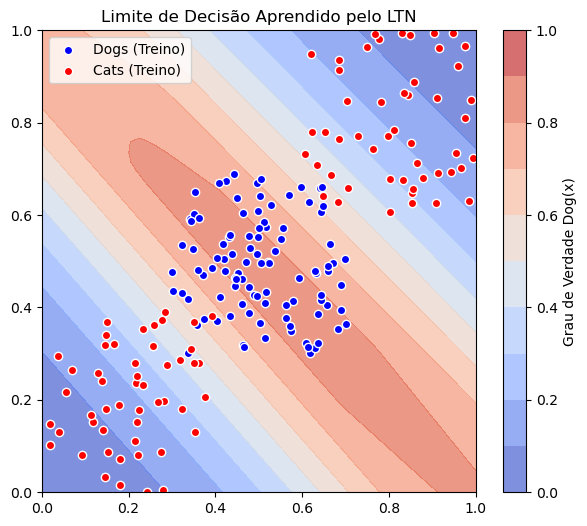

In [13]:
# --- 4. Teste e Visualização na Grade ---

# "Cria uma grade de pontos para testar o modelo"
grid_size = 50
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_torch = torch.tensor(grid_points, dtype=torch.float32).to(device)

# Converte a grade em Variável LTN para o predicado aceitar
grid_var = ltn.Variable("grid", grid_torch)

# Consulta o predicado em cada ponto... mapa de calor"
with torch.no_grad():
    result_ltn = Dog(grid_var)
    # Acessa .value para pegar o tensor de volta
    truth_values = result_ltn.value.detach().cpu().numpy()

# Plotagem
zz = truth_values.reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, zz, levels=np.linspace(0, 1, 11), cmap="coolwarm", alpha=0.7)
plt.colorbar(label='Grau de Verdade Dog(x)')

# Plota os dados originais por cima
plt.scatter(dogs_data.cpu()[:, 0], dogs_data.cpu()[:, 1], label='Dogs (Treino)', c='blue', edgecolors='white')
plt.scatter(cats_data.cpu()[:, 0], cats_data.cpu()[:, 1], label='Cats (Treino)', c='red', edgecolors='white')

plt.title('Limite de Decisão Aprendido pelo LTN')
plt.legend()
plt.show()

Gerando Matriz de Confusão...


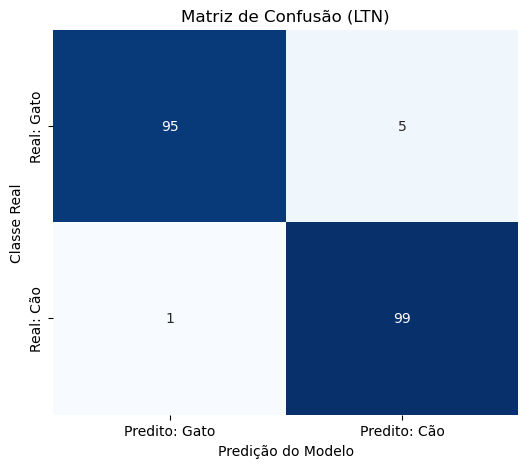

Acurácia Final: 97.00%


In [14]:
# --- BLOCO 5: Avaliação com Matriz de Confusão ---
print("Gerando Matriz de Confusão...")

# 1. Preparar os dados para avaliação
with torch.no_grad():
    # .squeeze() garante que o array seja unidimensional (N,) e não (N, 1)
    pred_dogs = Dog(ltn.Variable("dogs_eval", dogs_data)).value.squeeze()
    pred_cats = Dog(ltn.Variable("cats_eval", cats_data)).value.squeeze()

# 2. Concatenar predições
all_preds_scores = torch.cat((pred_dogs, pred_cats)).cpu().numpy()

# 3. Criar Ground Truth (Rótulos Reais)
# 100 dogs (classe 1) e 100 cats (classe 0)
true_labels = np.concatenate([
    np.ones(len(dogs_data)),
    np.zeros(len(cats_data))
])

# 4. Binarizar a saída (Threshold 0.5)
predicted_labels = (all_preds_scores > 0.5).astype(int)

# 5. Calcular Matriz
cm = confusion_matrix(true_labels, predicted_labels)

# 6. Plotar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predito: Gato', 'Predito: Cão'],
            yticklabels=['Real: Gato', 'Real: Cão'])
plt.xlabel('Predição do Modelo')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão (LTN)')
plt.show()

# Acurácia
acc = (cm[0,0] + cm[1,1]) / cm.sum()
print(f"Acurácia Final: {acc * 100:.2f}%")